In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
from datetime import datetime
import numpy as np

import utils
from vgg19 import Vgg19
import config



In [2]:
# define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
 # load and reshape the content image
content_img = utils.load_image(os.path.join(config.CONTENT_DIR,config.content_name),config.HEIGHT)
# load and reshape the style image
style_img = utils.load_image(os.path.join(config.STYLE_DIR,config.style_name),config.HEIGHT) 
content_img.shape,style_img.shape

((400, 653, 3), (400, 505, 3))

In [4]:
# use the pretrained model VGG19
model = Vgg19() 

In [5]:
# transform the content image into tensor and more 
content_transformed = utils.transform_image(content_img,device) 
# transform the style image into tensor and more
style_transformed = utils.transform_image(style_img,device) 
content_transformed.shape,style_transformed.shape

(torch.Size([1, 3, 400, 653]), torch.Size([1, 3, 400, 505]))

In [6]:
init_img = content_transformed # define the init image (it can be random noise, content or style)
optimizing_img = Variable(init_img,requires_grad=True) # define the variables who will be optimize to reduce loss (we optimize image's pixels)

In [7]:
content_set_features_map = model(content_transformed)# get the set of features map of content image 
style_set_features_map = model(style_transformed)# get the set of features map of style image 
len(content_set_features_map),len(style_set_features_map)

(6, 6)

In [8]:
print(f"INITIAL: content shape:{content_transformed.shape} | style shape:{style_transformed.shape}")
for i in range(len(content_set_features_map)):
    print(f"{i}:content shape:{content_set_features_map[i].shape} | style shape:{style_set_features_map[i].shape}")

INITIAL: content shape:torch.Size([1, 3, 400, 653]) | style shape:torch.Size([1, 3, 400, 505])
0:content shape:torch.Size([1, 64, 400, 653]) | style shape:torch.Size([1, 64, 400, 505])
1:content shape:torch.Size([1, 128, 200, 326]) | style shape:torch.Size([1, 128, 200, 252])
2:content shape:torch.Size([1, 256, 100, 163]) | style shape:torch.Size([1, 256, 100, 126])
3:content shape:torch.Size([1, 512, 50, 81]) | style shape:torch.Size([1, 512, 50, 63])
4:content shape:torch.Size([1, 512, 50, 81]) | style shape:torch.Size([1, 512, 50, 63])
5:content shape:torch.Size([1, 512, 25, 40]) | style shape:torch.Size([1, 512, 25, 31])


In [9]:
optimizer = torch.optim.LBFGS([optimizing_img],max_iter=config.ITERATION,line_search_fn="strong_wolfe")

In [10]:
target_content = content_set_features_map[config.target_content_layer]
target_style = [utils.gram_matrix(x) for i,x in enumerate(style_set_features_map) if i in config.target_style_layer]

In [11]:

def loss_fn(model, target_content, target_style, current_img):
    current_img_set_features_map = model(current_img)

    # Content Loss
    content_loss_fn = torch.nn.MSELoss(reduction="mean")
    content_loss = content_loss_fn(target_content, current_img_set_features_map[4])

    # Style Loss
    style_loss_fn = torch.nn.MSELoss(reduction="sum")
    style_loss = 0.0
    current_style_representation = [utils.gram_matrix(x) for i, x in enumerate(current_img_set_features_map) if i != 4]
    for gram_target, gram_current in zip(target_style, current_style_representation):
        style_loss += style_loss_fn(gram_target, gram_current)
    style_loss /= len(current_style_representation)
    
    #total variation loss
    tv = utils.total_variation(optimizing_img)

    # Total loss
    total_loss = (content_loss * config.CONTENT_WEIGHT) + (style_loss*config.STYLE_WEIGHT) + (tv*config.TV_WEIGHT)
    return total_loss
    

In [12]:
dir_name = f"{config.content_name}_{config.style_name}"
os.makedirs(dir_name,exist_ok=True)

In [13]:
counter = 0

def optimize_step():
    global counter
    optimizer.zero_grad()
    total_loss = loss_fn(model, target_content, target_style, optimizing_img)
    total_loss.backward()
    print(f"iteration:{counter} total_loss:{total_loss.item()}")
    counter+=1
    return total_loss

# Perform optimization
optimizer.step(optimize_step)
    

iteration:0 total_loss:1733879791616.0
iteration:1 total_loss:1733879660544.0
iteration:2 total_loss:1733879398400.0
iteration:3 total_loss:1733879398400.0
iteration:4 total_loss:1733879398400.0
iteration:5 total_loss:1725762633728.0
iteration:6 total_loss:1656571691008.0
iteration:7 total_loss:976774430720.0
iteration:8 total_loss:782859173888.0
iteration:9 total_loss:609286881280.0
iteration:10 total_loss:509080961024.0
iteration:11 total_loss:382778310656.0
iteration:12 total_loss:297216409600.0
iteration:13 total_loss:271404892160.0
iteration:14 total_loss:238138556416.0
iteration:15 total_loss:207250571264.0
iteration:16 total_loss:171926437888.0
iteration:17 total_loss:143702179840.0
iteration:18 total_loss:136991891456.0
iteration:19 total_loss:124470583296.0
iteration:20 total_loss:115498483712.0
iteration:21 total_loss:104481775616.0
iteration:22 total_loss:92737462272.0
iteration:23 total_loss:76043411456.0
iteration:24 total_loss:69385306112.0
iteration:25 total_loss:6657870

tensor(1.7339e+12, grad_fn=<AddBackward0>)

In [14]:
final_img = optimizing_img.squeeze().permute(1,2,0).to('cpu').detach().numpy()
final_img = utils.get_uint8_range(final_img)
final_img /=255
final_img.shape

(400, 653, 3)

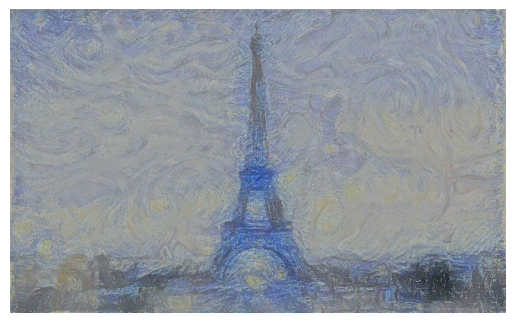

In [15]:
utils.display_image(final_img)

In [16]:
result_name = utils.get_name(config.content_name,config.style_name)
result_img_path = os.path.join(config.RESULT_DIR, f"{result_name}.png")
plt.imsave(result_img_path, final_img)